# FastAI.jl VAE Demo

In [1]:
using CUDA
using FastAI
using FastAI: FluxTraining
using MLDataPattern
using Flux
using Flux.Zygote: Params
using Flux.Optimise: update!
using Statistics: mean
using StaticArrays
using Colors
using Images

We will train a variational auto-encoder (VAE) model to encode images from the MNIST dataset to latent space, while still being able to accurately decode the latent samples.

The overall pipeline looks like this:

![Diagram of VAE](https://github.com/darsnack/fastai-vae-demo/raw/main/vae.png)

As you can see, this is an unsupervised learning scheme, since we only need input images (no labels). Below, we'll demonstrate how FastAI.jl handles this unconventional training flow.

In [2]:
function Base.show(io::IO, method::BlockMethod{<:FastAI.Block})
    print(io, "BlockMethod(", typeof(method.blocks), " -> ", typeof(method.blocks), ")")
end

function FastAI.BlockMethod(block::FastAI.Block, encodings; outputblock = FastAI.encodedblock(encodings, block))
    return BlockMethod(block, encodings, outputblock)
end

function FastAI.plotsample!(f, method::BlockMethod{<:FastAI.Block}, sample)
	blocks = (method.blocks, method.blocks)
    contexts = FastAI.plotcontext(blocks)
    FastAI.plotsample!(f, contexts, blocks, sample)
end

function FastAI.plotxy!(f, method::BlockMethod{<:FastAI.Block}, x, x̂)
    input, target = decode(
		method.encodings,
		Validation(),
		(method.outputblock, method.outputblock),
		(x, x̂))
    FastAI.plotsample!(f, method, (input, target))
end

FastAI.plotblock!(ax, ::Image{2}, data; kwargs...) = FastAI.plotimage!(ax, clamp01.(data); kwargs...)

## Loading the data

Below, we load the MNIST dataset just like we would for supervised training. No changes required here!

In [3]:
path = datasetpath("mnist_png")
data = Datasets.loadfolderdata(path,
                               filterfn = isimagefile,
                               splitfn = grandparentname,
                               loadfn = (loadfile, parentname))

Dict{String, Tuple{FastAI.Datasets.MappedData{typeof(loadfile), SubArray{String, 1, Vector{String}, Tuple{Vector{Int64}}, false}}, FastAI.Datasets.MappedData{typeof(parentname), SubArray{String, 1, Vector{String}, Tuple{Vector{Int64}}, false}}}} with 2 entries:
  "testing"  => (mapobs(loadfile, ["/home/daruwalla/.julia/datadeps/fastai-mnis…
  "training" => (mapobs(loadfile, ["/home/daruwalla/.julia/datadeps/fastai-mnis…

We also define a `BlockMethod` using the same syntax as before except we don't specify a label.

In [4]:
method = BlockMethod(
	Image{2}(),
	(ImagePreprocessing(means=SVector(0.0,), stds=SVector(1.), C=Gray{Float32})),
)

BlockMethod(Image{2} -> Image{2})

## Custom model and loss function

Next we create a VAE model composed of a two layer MLP for the encoder and decoder. Our latent space will be two dimensional (we are encoding a 28x28 image to 2D!).

In [5]:
Din = prod(size(getobs(data["training"][1], 1)))
Dhidden = 512
Dlatent = 2

encoder = Chain(Dense(Din, Dhidden, relu), # backbone
                Parallel(tuple,
                         Dense(Dhidden, Dlatent), # μ
                         Dense(Dhidden, Dlatent)  # logσ²
                         )) |> gpu

Chain(
  Dense(784, 512, relu),                # 401_920 parameters
  Parallel(
    tuple,
    Dense(512, 2),                      # 1_026 parameters
    Dense(512, 2),                      # 1_026 parameters
  ),
)                   # Total: 6 arrays, 403_972 parameters, 528 bytes.

In [6]:
decoder = Chain(Dense(Dlatent, Dhidden, relu), Dense(Dhidden, Din, sigmoid)) |> gpu

Chain(
  Dense(2, 512, relu),                  # 1_536 parameters
  Dense(512, 784, σ),                   # 402_192 parameters
)                   # Total: 4 arrays, 403_728 parameters, 312 bytes.

We also define a custom loss function (called the ELBO) and a utility to help us sample the latent space

In [7]:
sample_latent(μ::AbstractArray{T}, logσ²::AbstractArray{T}) where T =
    μ .+ exp.(logσ² ./ 2) .* randn(T, size(logσ²))

sample_latent(μ::CuArray{T}, logσ²::CuArray{T}) where T =
    μ .+ exp.(logσ² ./ 2) .* gpu(randn(T, size(logσ²)))

function βELBO(x, x̄, μ, logσ²; β = 1)
    reconstruction_error = mean(sum(@.((x̄ - x)^2); dims = 1))
    # D(N(μ, Σ)||N(0, I)) = 1/2 * (μᵀμ + tr(Σ) - length(μ) - log(|Σ|))
    kl_divergence = mean(sum(@.((μ^2 + exp(logσ²) - 1 - logσ²) / 2); dims = 1))

    return reconstruction_error + β * kl_divergence
end

βELBO (generic function with 1 method)

## Creating a `Learner`

Now we instantiate FastAI.jl's `Learner` which encapsulates our training data, model, loss function, and optimizer. Notice that we didn't do anything special for our data, model, or loss that wasn't present in an image classification example.

In [14]:
model = (encoder = encoder, decoder = decoder)
opt = ADAM(1e-3)
dataiter = DataLoader(batchviewcollated(methoddataset(data["training"][1], method, Training()), 128); buffered = false)
learner = Learner(model, (training = dataiter,), opt, βELBO, ToGPU())
FluxTraining.removecallback!(learner, ProgressPrinter)
;

## Custom training loop

When dealing with a unconvential learning scheme, we usually need to write a custom training loop. FastAI.jl is build on top of FluxTraining.jl which makes writing custom loops easy. In fact, the built-in learning schemes use the _exact_ same framework as you'll see below.

In [10]:
struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

We just defined our own training phase. All that's required for our phase to take advantage of the FastAI.jl framework is to define the `FluxTraining.step!` function. We'll use a utility, `FluxTraining.runstep`, to make handling callback events, etc. simple. `runstep`'s first argument is a function with inputs `(handle, state)`. `handle` is how we indicate different events, such as the start of the gradient computation, to FluxTraining's loop system. `state` holds data generated on each call to `step!` like the batch, gradients, and loss. We initialize it to contain our batch: `(x = batch,)`.

In [11]:
function FluxTraining.step!(learner, phase::VAETrainingPhase, batch)
    FluxTraining.runstep(learner, phase, (x = batch,)) do handle, state
        ps = union(learner.params...)
        x = flatten(dropdims(state.x; dims = ndims(state.x)))
        gs = gradient(ps) do
            # get encode, sample latent space, decode
            μ, logσ² = learner.model.encoder(x)
            z = sample_latent(μ, logσ²)
            x̄ = learner.model.decoder(z)

            handle(FluxTraining.LossBegin())
            state.loss = learner.lossfn(x, x̄, μ, logσ²)

            handle(FluxTraining.BackwardBegin())
            return state.loss
        end
        handle(FluxTraining.BackwardEnd())
        update!(learner.optimizer, ps, gs)
    end
end

# for ToGPU to work
function FluxTraining.on(::FluxTraining.StepBegin, ::VAETrainingPhase, cb::ToDevice, learner)
    learner.step.x = cb.movedatafn(learner.step.x)
end

## Training the model

And that's it! We can now train our model like any other `Learner` in FastAI.jl. We just need to specify that the `VAETrainingPhase` should be run instead of the default `FluxTraining.TrainingPhase`.

In [22]:
for epoch in 1:30
    epoch!(learner, VAETrainingPhase())
end

┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  11.0 │ 42.5983 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  12.0 │ 42.3849 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  13.0 │ 42.3046 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  14.0 │ 42.1716 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  15.0 │ 42.0651 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  16.0 │ 42.1084 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  17.0 │ 41.9515 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  18.0 │ 41.8969 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  19.0 │ 41.7652 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  20.0 │ 41.6746 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  21.0 │ 41.6284 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  22.0 │ 41.5284 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  23.0 │ 41.4756 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  24.0 │ 41.4307 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  25.0 │ 41.3747 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  26.0 │ 41.2909 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  27.0 │ 41.2312 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬────────┐
│            Phase │ Epoch │   Loss │
├──────────────────┼───────┼────────┤
│ VAETrainingPhase │  28.0 │ 41.127 │
└──────────────────┴───────┴────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  29.0 │ 41.1028 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  30.0 │ 41.0604 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬────────┐
│            Phase │ Epoch │   Loss │
├──────────────────┼───────┼────────┤
│ VAETrainingPhase │  31.0 │ 40.917 │
└──────────────────┴───────┴────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  32.0 │ 40.9141 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬────────┐
│            Phase │ Epoch │   Loss │
├──────────────────┼───────┼────────┤
│ VAETrainingPhase │  33.0 │ 40.871 │
└──────────────────┴───────┴────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  34.0 │ 40.8114 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  35.0 │ 40.7814 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  36.0 │ 40.7848 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  37.0 │ 40.7541 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  38.0 │ 40.7183 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  39.0 │ 40.6225 │
└──────────────────┴───────┴─────────┘


┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │  40.0 │ 40.6534 │
└──────────────────┴───────┴─────────┘


In [54]:
xs = makebatch(method, data["testing"][1], rand(1:nobs(data["testing"]), 5))
x̄s = decoder(sample_latent(encoder(flatten(gpu(xs)))...)) |> cpu
x̄s = reshape(x̄s, 28, 28, 1, :);

,,,,

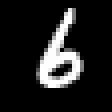
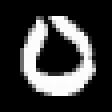
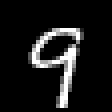
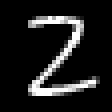
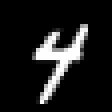

In [55]:
to_image(x) = Gray{N0f8}.(reshape(x, 28, 28))

[to_image(x) for x in eachslice(xs; dims = ndims(xs))]

,,,,

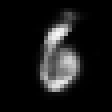
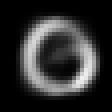
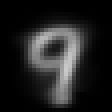
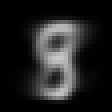
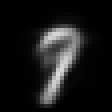

In [56]:
[to_image(x) for x in eachslice(x̄s; dims = ndims(x̄s))]